In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Using the previously calculated values (first notebook) of mean and std of the images in this dataset
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=10, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [19]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        #Initializing variable to collect grad norms 
        self._grad_norms = {}
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 16
        self.conv2_out_channels = 32
        self.conv3_out_channels = 64
        self.conv4_out_channels = 96
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = 128
        self.fc4_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.LeakyReLU(0.05)          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.LeakyReLU(0.05)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.LeakyReLU(0.05)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Fourth conv layer block
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_channels, out_channels=self.conv4_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.conv4_out_channels)
        self.act4 = nn.LeakyReLU(0.05)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.5)
        self.act_fc1 = nn.LeakyReLU(0.05)
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.3)
        self.act_fc2 = nn.LeakyReLU(0.05)
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.dropout3 = nn.Dropout(0.3)
        self.act_fc3 = nn.LeakyReLU(0.05)
        
        self.fc4 = nn.Linear(in_features=self.fc3_out_features, out_features=self.fc4_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.dropout3(self.act_fc2(self.fc3(x)))
        x = self.output_activation(self.fc4(x))
        
        return x

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,  # or specify manually
            eta_min=1e-5                    # minimum LR at end of schedule
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",       # step every epoch
                "monitor": "val_loss",     # not needed for CosineAnnealingLR, but OK to include
            },
        }
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        for param_group in self.trainer.optimizers[0].param_groups:
            print(f"Learning rate after epoch {self.current_epoch}: {param_group['lr']}")
        
        #Calculating average grad norms
        vanished_count = 0
        exploded_count = 0
        total_layers = len(self._grad_norms)

        for name, norms in self._grad_norms.items():
            avg_norm = sum(norms) / len(norms)

            # Log to TensorBoard
            self.logger.experiment.add_scalar(f"grad_norm_epoch_avg/{name}", avg_norm, self.current_epoch)

            # Stats
            if avg_norm < 1e-6:
                vanished_count += 1
            elif avg_norm > 100:
                exploded_count += 1

        # Log total stats
        self.log("grad_stats/total_layers", total_layers, on_epoch=True)
        self.log("grad_stats/vanished", vanished_count, on_epoch=True)
        self.log("grad_stats/exploded", exploded_count, on_epoch=True)

        print(f"[Epoch {self.current_epoch}] Grad Norms — Total: {total_layers}, Vanished: {vanished_count}, Exploded: {exploded_count}")

        # Reset buffer
        self._grad_norms.clear()
    

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")
    
    
    def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        for name, param in self.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                if name not in self._grad_norms:
                    self._grad_norms[name] = []
                self._grad_norms[name].append(norm)


In [20]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)
    

In [21]:
#Setting seed to fetch the same training data every time
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [22]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               
    save_weights_only=False                  # Save full model
)

In [23]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     # or "val_acc"
    patience=5,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [24]:
# Create logger
logger = TensorBoardLogger("tensorboard_logs", name="miniimagenet_cnn")

In [25]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [26]:
datamodule = DataModule(batch_size=128)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(logger=logger,
                     callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=30)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

   | Name              | Type        | Params | Mode 
-----------------------------------------------------------
0  | conv1             | Conv2d      | 448    | train
1  | bn1               | BatchNorm2d | 32     | train
2  | act1              | LeakyReLU   | 0      | train
3  | pool1             | MaxPool2d   | 0      | train
4  | conv2             | Conv2d      | 4.6 K  | train
5  | bn2               | BatchNorm2d | 64     | train
6  | act2              | LeakyReLU   | 0      | train
7  | pool2    

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]
Val - After Epoch 0: loss=3.908, acc=0.031
Epoch 0: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.11it/s, v_num=5]
Val - After Epoch 0: loss=3.547, acc=0.084
Epoch 0: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:39<00:00,  1.66it/s, v_num=5]

Metric val_loss improved. New best score: 3.547



Train - After Epoch 0: loss=3.782, acc=0.055
Learning rate after epoch 0: 0.0009972883382072953
[Epoch 0] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 1: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:21<00:00,  2.02it/s, v_num=5]
Val - After Epoch 1: loss=3.422, acc=0.112
Epoch 1: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:44<00:00,  1.58it/s, v_num=5]

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 3.422



Train - After Epoch 1: loss=3.555, acc=0.093
Learning rate after epoch 1: 0.0009891830623632338
[Epoch 1] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 2: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.09it/s, v_num=5]
Val - After Epoch 2: loss=3.339, acc=0.135
Epoch 2: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:39<00:00,  1.65it/s, v_num=5]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 3.339



Train - After Epoch 2: loss=3.450, acc=0.110
Learning rate after epoch 2: 0.0009757729755661011
[Epoch 2] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 3: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:17<00:00,  2.12it/s, v_num=5]
Val - After Epoch 3: loss=3.251, acc=0.155
Epoch 3: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:40<00:00,  1.64it/s, v_num=5]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 3.251



Train - After Epoch 3: loss=3.381, acc=0.128
Learning rate after epoch 3: 0.0009572050015330874
[Epoch 3] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 4: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:13<00:00,  2.26it/s, v_num=5]
Val - After Epoch 4: loss=3.175, acc=0.173
Epoch 4: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:35<00:00,  1.74it/s, v_num=5]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 3.175



Train - After Epoch 4: loss=3.315, acc=0.137
Learning rate after epoch 4: 0.0009336825748732973
[Epoch 4] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 5: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.19it/s, v_num=5]
Val - After Epoch 5: loss=3.119, acc=0.184
Epoch 5: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.71it/s, v_num=5]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 3.119



Train - After Epoch 5: loss=3.252, acc=0.151
Learning rate after epoch 5: 0.0009054634122155991
[Epoch 5] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 6: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:15<00:00,  2.19it/s, v_num=5]
Val - After Epoch 6: loss=3.067, acc=0.196
Epoch 6: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.71it/s, v_num=5]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 3.067



Train - After Epoch 6: loss=3.191, acc=0.166
Learning rate after epoch 6: 0.0008728566886113102
[Epoch 6] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 7: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:21<00:00,  2.01it/s, v_num=5]
Val - After Epoch 7: loss=2.999, acc=0.212
Epoch 7: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:44<00:00,  1.58it/s, v_num=5]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 2.999



Train - After Epoch 7: loss=3.150, acc=0.183
Learning rate after epoch 7: 0.0008362196501476349
[Epoch 7] Grad Norms — Total: 24, Vanished: 4, Exploded: 0
Epoch 8: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.10it/s, v_num=5]
Val - After Epoch 8: loss=3.002, acc=0.214
Epoch 8: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:41<00:00,  1.63it/s, v_num=5]
Train - After Epoch 8: loss=3.079, acc=0.192
Learning rate after epoch 8: 0.0007959536998847742
[Epoch 8] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 9: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:20<00:00,  2.06it/s, v_num=5]
Val - After Epoch 9: loss=2.909, acc=0.237
Epoch 9: 100%|██████████████████████████████████████████████████████████████| 165/165 [01:42<00:00,  1.61it/s, v_num=5]

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 2.909



Train - After Epoch 9: loss=3.023, acc=0.209
Learning rate after epoch 9: 0.0007525
[Epoch 9] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 10: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.10it/s, v_num=5]
Val - After Epoch 10: loss=2.853, acc=0.244
Epoch 10: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:41<00:00,  1.62it/s, v_num=5]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 2.853



Train - After Epoch 10: loss=2.990, acc=0.217
Learning rate after epoch 10: 0.0007063346383225212
[Epoch 10] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 11: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:20<00:00,  2.04it/s, v_num=5]
Val - After Epoch 11: loss=2.835, acc=0.250
Epoch 11: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:42<00:00,  1.60it/s, v_num=5]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 2.835



Train - After Epoch 11: loss=2.941, acc=0.225
Learning rate after epoch 11: 0.000657963412215599
[Epoch 11] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 12: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:16<00:00,  2.16it/s, v_num=5]
Val - After Epoch 12: loss=2.813, acc=0.262
Epoch 12: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:38<00:00,  1.68it/s, v_num=5]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 2.813



Train - After Epoch 12: loss=2.887, acc=0.235
Learning rate after epoch 12: 0.0006079162869547909
[Epoch 12] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 13: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:16<00:00,  2.15it/s, v_num=5]
Val - After Epoch 13: loss=2.741, acc=0.276
Epoch 13: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:39<00:00,  1.66it/s, v_num=5]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 2.741



Train - After Epoch 13: loss=2.848, acc=0.245
Learning rate after epoch 13: 0.0005567415893174886
[Epoch 13] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 14: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.22it/s, v_num=5]
Val - After Epoch 14: loss=2.731, acc=0.278
Epoch 14: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:36<00:00,  1.71it/s, v_num=5]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 2.731



Train - After Epoch 14: loss=2.822, acc=0.251
Learning rate after epoch 14: 0.0005050000000000002
[Epoch 14] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 15: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:19<00:00,  2.07it/s, v_num=5]
Val - After Epoch 15: loss=2.653, acc=0.295
Epoch 15: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:42<00:00,  1.61it/s, v_num=5]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 2.653



Train - After Epoch 15: loss=2.781, acc=0.261
Learning rate after epoch 15: 0.0004532584106825117
[Epoch 15] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 16: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:20<00:00,  2.04it/s, v_num=5]
Val - After Epoch 16: loss=2.603, acc=0.306
Epoch 16: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:43<00:00,  1.59it/s, v_num=5]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.603



Train - After Epoch 16: loss=2.746, acc=0.272
Learning rate after epoch 16: 0.00040208371304520916
[Epoch 16] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 17: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:19<00:00,  2.06it/s, v_num=5]
Val - After Epoch 17: loss=2.579, acc=0.311
Epoch 17: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:42<00:00,  1.60it/s, v_num=5]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 2.579



Train - After Epoch 17: loss=2.703, acc=0.278
Learning rate after epoch 17: 0.00035203658778440114
[Epoch 17] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 18: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:17<00:00,  2.12it/s, v_num=5]
Val - After Epoch 18: loss=2.558, acc=0.320
Epoch 18: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:40<00:00,  1.64it/s, v_num=5]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 2.558



Train - After Epoch 18: loss=2.677, acc=0.284
Learning rate after epoch 18: 0.000303665361677479
[Epoch 18] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 19: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:21<00:00,  2.03it/s, v_num=5]
Val - After Epoch 19: loss=2.549, acc=0.315
Epoch 19: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:44<00:00,  1.58it/s, v_num=5]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 2.549



Train - After Epoch 19: loss=2.643, acc=0.292
Learning rate after epoch 19: 0.0002575000000000002
[Epoch 19] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 20: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:20<00:00,  2.06it/s, v_num=5]
Val - After Epoch 20: loss=2.486, acc=0.331
Epoch 20: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:40<00:00,  1.64it/s, v_num=5]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 2.486



Train - After Epoch 20: loss=2.602, acc=0.300
Learning rate after epoch 20: 0.0002140463001152259
[Epoch 20] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 21: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:16<00:00,  2.15it/s, v_num=5]
Val - After Epoch 21: loss=2.461, acc=0.341
Epoch 21: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:37<00:00,  1.69it/s, v_num=5]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 2.461



Train - After Epoch 21: loss=2.581, acc=0.305
Learning rate after epoch 21: 0.00017378034985236537
[Epoch 21] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 22: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:16<00:00,  2.16it/s, v_num=5]
Val - After Epoch 22: loss=2.463, acc=0.344
Epoch 22: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:38<00:00,  1.67it/s, v_num=5]
Train - After Epoch 22: loss=2.556, acc=0.316
Learning rate after epoch 22: 0.00013714331138868995
[Epoch 22] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 23: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:14<00:00,  2.21it/s, v_num=5]
Val - After Epoch 23: loss=2.435, acc=0.352
Epoch 23: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:38<00:00,  1.67it/s, v_num=5]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 2.435



Train - After Epoch 23: loss=2.544, acc=0.314
Learning rate after epoch 23: 0.00010453658778440111
[Epoch 23] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 24: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.10it/s, v_num=5]
Val - After Epoch 24: loss=2.435, acc=0.348
Epoch 24: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:42<00:00,  1.61it/s, v_num=5]
Train - After Epoch 24: loss=2.520, acc=0.322
Learning rate after epoch 24: 7.631742512670288e-05
[Epoch 24] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 25: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:19<00:00,  2.07it/s, v_num=5]
Val - After Epoch 25: loss=2.397, acc=0.353
Epoch 25: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:45<00:00,  1.57it/s, v_num=5]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.397



Train - After Epoch 25: loss=2.497, acc=0.324
Learning rate after epoch 25: 5.279499846691254e-05
[Epoch 25] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 26: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:18<00:00,  2.10it/s, v_num=5]
Val - After Epoch 26: loss=2.396, acc=0.366
Epoch 26: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:41<00:00,  1.62it/s, v_num=5]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 2.396



Train - After Epoch 26: loss=2.504, acc=0.326
Learning rate after epoch 26: 3.422702443389901e-05
[Epoch 26] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 27: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:20<00:00,  2.05it/s, v_num=5]
Val - After Epoch 27: loss=2.382, acc=0.358
Epoch 27: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:43<00:00,  1.59it/s, v_num=5]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 2.382



Train - After Epoch 27: loss=2.478, acc=0.328
Learning rate after epoch 27: 2.0816937636766188e-05
[Epoch 27] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 28: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:20<00:00,  2.05it/s, v_num=5]
Val - After Epoch 28: loss=2.384, acc=0.362
Epoch 28: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:41<00:00,  1.63it/s, v_num=5]
Train - After Epoch 28: loss=2.473, acc=0.330
Learning rate after epoch 28: 1.2711661792704668e-05
[Epoch 28] Grad Norms — Total: 24, Vanished: 3, Exploded: 0
Epoch 29: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:10<00:00,  2.35it/s, v_num=5]
Val - After Epoch 29: loss=2.373, acc=0.358
Epoch 29: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=5]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 2.373



Train - After Epoch 29: loss=2.468, acc=0.336
Learning rate after epoch 29: 1e-05
[Epoch 29] Grad Norms — Total: 24, Vanished: 3, Exploded: 0


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|█████████████████████████████████████████████████████████████| 165/165 [01:30<00:00,  1.82it/s, v_num=5]


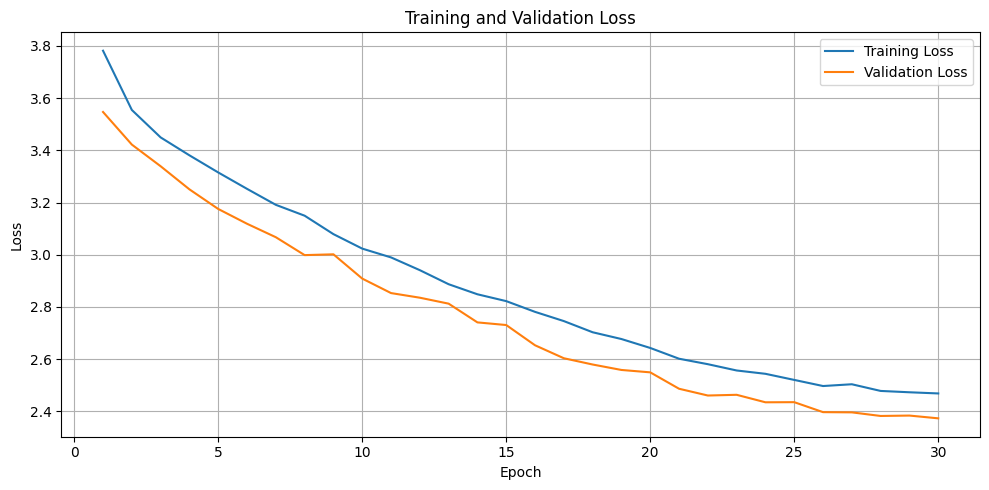

In [27]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

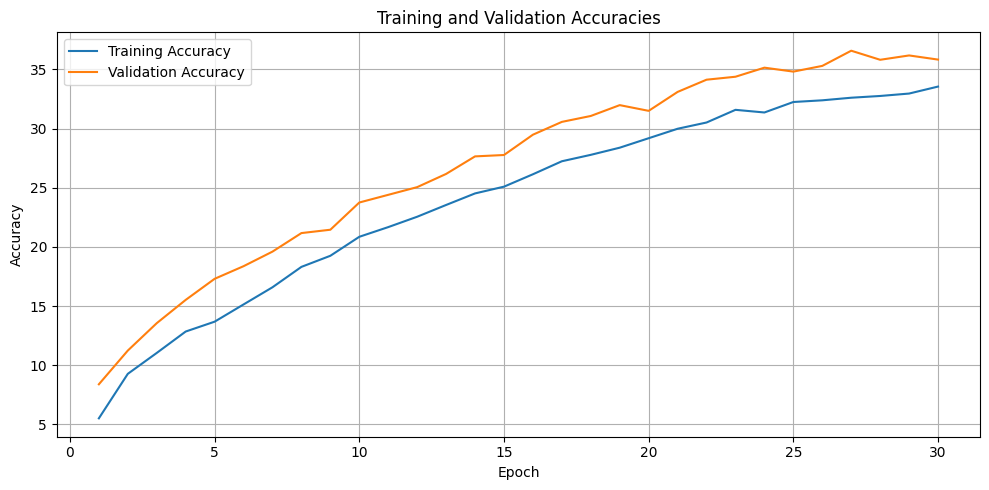

In [28]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[1:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()